In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from datetime import datetime, timedelta
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from spellchecker import SpellChecker
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import spacy
import swifter
from spacy.lang.en import English
from sklearn.base import BaseEstimator, TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
import contractions
pd.set_option('display.max_colwidth', None)


In [2]:
df = pd.read_csv(r'C:\Users\Owner\Desktop\Mangimind Data Science Bootcamp\Machine Learning Project 3\tweet_data.csv\tweet_data.csv')

In [3]:
convert_dict = {'tweetID': str,
                'crDate': 'datetime64[ns]',
                'rtUsID': str,
                'usID': str }
df = df.astype(convert_dict)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   tweetID     785916 non-null  object        
 1   crDate      785916 non-null  datetime64[ns]
 2   edInput     785916 non-null  int64         
 3   editor      785916 non-null  int64         
 4   engages     785916 non-null  int64         
 5   isApproved  785916 non-null  bool          
 6   isEdNeed    785916 non-null  bool          
 7   isRT        785916 non-null  bool          
 8   likes       785916 non-null  int64         
 9   photoUrl    277896 non-null  object        
 10  retweets    785916 non-null  int64         
 11  rtUsID      785916 non-null  object        
 12  text        785916 non-null  object        
 13  topicName   785916 non-null  object        
 14  usFlwrs     785916 non-null  int64         
 15  usID        785916 non-null  object        
 16  us

In [5]:
#Let's have a look at the text 

list(df.iloc[11:19,12])#,list(df.iloc[11:19,2])

['Wall Street recovers slightly from earlier losses spurred by fears of U.S.-China tensions over trade, lower oil prices https://t.co/VPvaB9zruP https://t.co/0YOxbR7cAu',
 'New research suggests you should set harder goals\nhttps://t.co/GwI4wT7Uzr',
 'Judge orders U.S. State Department to disclose possible evidence whether Hillary Clinton used her private email to flout public information requests https://t.co/TTcrPnjQwD',
 '#RajasthanElection2018 LIVE: Voting begins, Satta market bets big on @INCIndia\n\nCatch #live updates here\n\n#RajasthanAssemblyelection2018 #RajasthanElections2018 #RajasthanElections\n\nhttps://t.co/mzTsOMm9an',
 "A room full of Alpine cheese is one of Bloomberg's photos of the week 🧀🧀🧀https://t.co/22LMFT1A6S https://t.co/D6PXWArXyb",
 '#TelanganaElection2018 LIVE: @narendramodi , @AmitShah urge people to vote in large numbers\n\nCatch all the #live updates here \n\n #TelanganaElections #TelanganaAssemblyElections2018 #TelanganaElections2018 #Telangana\n\nhttps:/

In [6]:
# -1 unlabled data
# 1 confirmed by the editor that they are business calss
# 2 they confirmed they are misclassified. Editor does not agree
# 3 editor is confused
# 4 they are business but they were posted previously from another channel. If 4  it will noty be posted ot the user.
# eliminate three and four. Might want to included by relabling 4 as 1.
# stratification means your test splites has the same representation of all the classes. If your original has 30% of label 1 and 60 of label 2 your 
filtered_df = df[df['edInput'].isin([1,2])]
filtered_df['edInput'] = filtered_df['edInput'].replace(2,0)

C:\Users\Owner\AppData\Local\Temp\ipykernel_19228\2910846101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['edInput'] = filtered_df['edInput'].replace(2,0)


In [7]:
filtered_text = filtered_df['text'].astype(str).tolist()

In [8]:
filtered_text

['Which one would you choose? 👀 https://t.co/U0s3alfBNp',
 'How it’s made. 😊 https://t.co/3XjOw4gIkg',
 'Smile, because it confuses people. Smile, because it’s easier than explaining what is killing you inside. https://t.co/FGlnnRfP5w',
 '𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw',
 'Baby Alpacas are so under appreciated. https://t.co/SDXjKaVscv',
 'Felt cute. Might delete later. https://t.co/l2QLcKiAcq',
 'Sunflower pendants 🌻 https://t.co/ZgTdKi0cLe',
 'I need one. https://t.co/liHRWy7X7l',
 'For some people the idea of compassion entails a complete disregard for or even a sacrifice of their own interests. This is not the case. In fact, we first of all have to have a wish to be happy ourselves – if we don’t love ourselves like that, how can we love others?',
 'big hop energy\n\n📹: bferber https://t.co/k53vusKn88',
 'Jeopardy is lit now 😂😂 https://t.co/AhfKHlZymr',
 'Could you say no to that face? 😫🔈\n\n📹: bobby_frenchbulldog https://t.co/qcEqfChYvY',
 'm o o d\n\n📹: whiskeyretriever https

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
def generate_word_frequency(df_column, top_n=20):
    words = " ".join(df_column).split()
    word_freq = Counter(words)
    
    # Top N most frequent words
    top_words = word_freq.most_common(top_n)
    words, frequencies = zip(*top_words)
    
    # Plot the word frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequencies')
    plt.xticks(rotation=90)
    plt.show()

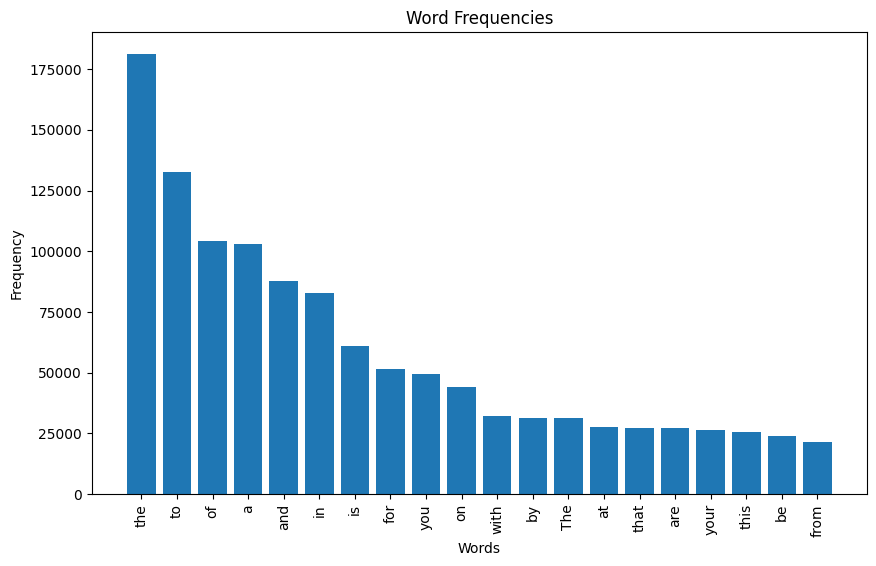

In [10]:
generate_word_frequency(filtered_text, top_n=20)

In [11]:
stop_words = ['the', 'to', 'of', 'a', 'and', 'in', 'is','for', 
              'you','on','with', 'by', 'The', 'at', 'that', 'are', 'your', 'this', 'be', 'from']

test_string = ['@josejalepano Cats with the craziest fur markings ever', 'Until you start focusing on what needs to be done, rather than what is politically possible, there is no hope. #jesus']

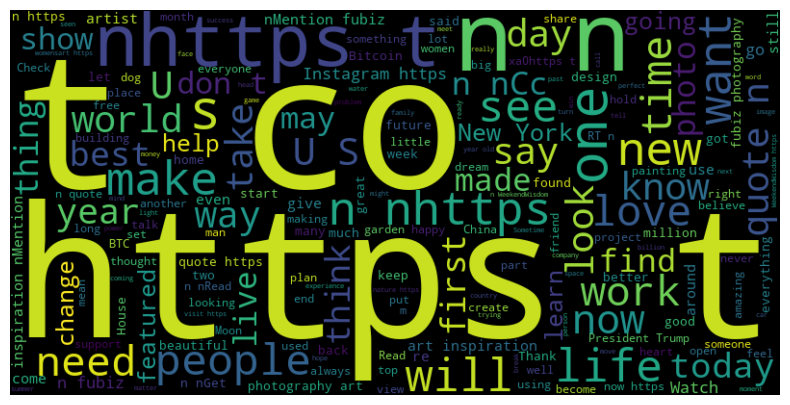

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(str(filtered_text))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
import re
import spacy
import contractions
import demoji
from tqdm import tqdm

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 5000000
from spacy.lang.en.stop_words import STOP_WORDS
# Function to preprocess text
def preprocess_text(texts):
    processed_parts = []
    for text in tqdm(texts, desc='Preprocessing', leave=False):
        # Convert text to lowercase.
        text = str(text).lower()

        # Remove twitter links
        twitter_url = re.compile(r'https?://t\.co/[^\s]+')
        text = twitter_url.sub('', text)
        
        # # Handling mentions
        text = re.sub(r'@[\w_]+', '', text)

        # Handling hashtags
        text = re.sub(r'#\w+', '', text)

        # Define the chunk size
        chunk_size = 500

        # Process the text in smaller parts
        processed_chunks = []
        for i in range(0, len(text), chunk_size):
            chunk = text[i:i+chunk_size]

            # Remove emojis from the chunk
            chunk = demoji.replace(chunk, "")

            # Expand contractions
            chunk = contractions.fix(chunk)
            
            # # Removing punctuation
            chunk = re.sub(r'[^\w\s]', '', chunk)

            # Lemmatize text
            doc = nlp(chunk)
            processed_chunk = " ".join([token.lemma_ for token in doc])

            # Remove stop words
#             stop_words = nlp.Defaults.stop_words
#             processed_chunk = " ".join([word for word in processed_chunk.split() if word not in stop_words])
            processed_chunk = " ".join([word for word in processed_chunk.split() if word not in stop_words])

            # Replace \n with space character
            processed_chunk = re.sub(r'\n+', ' ', processed_chunk)

            # Remove special characters
            processed_chunk = re.sub(r'[^a-zA-Z0-9\s]', '', processed_chunk)

            # Replace multiple spaces with a single space
            processed_chunk = re.sub(r'\s+', ' ', processed_chunk)

            # Remove leading and trailing spaces if any
            processed_chunk = processed_chunk.strip()

            processed_chunks.append(processed_chunk)

        processed_parts.extend(processed_chunks)

    return processed_parts


In [14]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 5000000
processed_text = preprocess_text(filtered_text)

In [15]:
print(len(processed_text))

322318


In [16]:
symbol_dict = {
    '&': ' and',
    '@': ' at',
    '#': ' number',
    '$': ' dollar',
    '%': ' percent',
    '*': ' asterisk',
    '+': ' plus',
    '-': ' minus',
    '/': ' slash',
    '\\': ' backslash',
    '=': ' equal',
    '^': ' caret',
    '_': ' underscore',
    '`': ' backtick',
    '~': ' tilde',
    '<': ' less than',
    '>': ' greater than',
    '(': ' left parenthesis',
    ')': ' right parenthesis',
    '[': ' left square bracket',
    ']': ' right square bracket',
    '{': ' left curly brace',
    '}': ' right curly brace',
    '|': ' pipe',
    ':': ' colon',
    ';': ' semicolon',
    ',': ' comma',
    '.': ' period',
    '?': ' question mark',
    '!': ' exclamation mark',
    '"': ' double quotation mark',
    "'": ' single quotation mark',
    '“': ' left double quotation mark',
    '”': ' right double quotation mark',
    '‘': ' left single quotation mark',
    '’': ' right single quotation mark',
    '…': ' ellipsis',}

In [17]:
processed_text

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 '',
 'baby alpaca so under appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy bferber',
 'jeopardy light now',
 'could say no face bobbyfrenchbulldog',
 'm o o d whiskeyretriever',
 'aroma restaurant rome italy',
 'faa sai rescue elephant she naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'selfrolling burrito kimcheethemaltipoo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinklybulldog',
 'which one favourite',
 'good feeling world',
 'puppermelon',
 'christmas christian dior',
 'do not say anything just retweet',
 'make my day',
 '12 r

In [18]:
def replace_keys_with_values(text_list, symbol_dict):
    # Iterate over the list and replace keys with their values
    for i in range(len(text_list)):
        for key, value in symbol_dict.items():
            text_list[i] = text_list[i].replace(key, value)
    return text_list

In [19]:
processed_text_key_to_text = replace_keys_with_values(processed_text,symbol_dict)
processed_text_key_to_text

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 '',
 'baby alpaca so under appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy bferber',
 'jeopardy light now',
 'could say no face bobbyfrenchbulldog',
 'm o o d whiskeyretriever',
 'aroma restaurant rome italy',
 'faa sai rescue elephant she naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'selfrolling burrito kimcheethemaltipoo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinklybulldog',
 'which one favourite',
 'good feeling world',
 'puppermelon',
 'christmas christian dior',
 'do not say anything just retweet',
 'make my day',
 '12 r

In [20]:
import re
import wordninja

# List of sentences
# processed_text_key_to_text = ['this is p o s i t i v i t y', 't h i s is positivity',
#                     'another t e s t case', 'v a r i a b i l i t y is w e i r d']

corrected_texts = []

with tqdm(total=len(processed_text_key_to_text), desc='Processing Texts', unit='text') as pbar:
    for text in processed_text_key_to_text:
        # Split the sentence into phrases based on two or more spaces
        phrases = re.split('  +', text)

        # For each phrase, remove single spaces and join them back together into a sentence
        new_text = ' '.join([phrase.replace(' ', '') for phrase in phrases])

        # Use wordninja to split concatenated words
        split_words = ' '.join(wordninja.split(new_text))

        # Correct the specific splitting error for "positivity"
        corrected_words = split_words.replace('positiv it y', 'positivity')

        corrected_texts.append(corrected_words)
        pbar.update(1)
# Print the corrected texts
# for corrected_text in corrected_texts:
#     print(corrected_text)

Processing Texts: 100%|████████████████████████████████████████████████████| 322318/322318 [04:50<00:00, 1109.39text/s]


In [21]:
len(corrected_texts)
corrected_texts[0:100]

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 '',
 'baby alpaca sounder appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy b ferber',
 'jeopardy light now',
 'could say no face bobby french bulldog',
 'mood whiskey retriever',
 'aroma restaurant rome italy',
 'fa asai rescue elephants he naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'self rolling burrito kim chee the malt i poo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinkly bulldog',
 'which one favourite',
 'good feeling world',
 'p upper melon',
 'christmas christian dior',
 'do not say anything just re tweet',
 'make my da

In [22]:
from num2words import num2words

def convert_numeric_to_text(text_list):
    converted_text_list = []
    for text in text_list:
        words = text.split()
        converted_words = []
        for word in words:
            if word.isdigit():
                converted_words.append(num2words(int(word)))
            else:
                converted_words.append(word)
        converted_text_list.append(" ".join(converted_words))
    return converted_text_list

processed_text_numeric_to_text = convert_numeric_to_text(corrected_texts)
processed_text_numeric_to_text

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 '',
 'baby alpaca sounder appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy b ferber',
 'jeopardy light now',
 'could say no face bobby french bulldog',
 'mood whiskey retriever',
 'aroma restaurant rome italy',
 'fa asai rescue elephants he naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'self rolling burrito kim chee the malt i poo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinkly bulldog',
 'which one favourite',
 'good feeling world',
 'p upper melon',
 'christmas christian dior',
 'do not say anything just re tweet',
 'make my da

In [23]:
import wordninja
# Space combined words
new_processed_text_numeric_to_text = [' '.join(wordninja.split(text)) for text in processed_text_numeric_to_text]
new_processed_text_numeric_to_text

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 '',
 'baby alpaca sounder appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy b ferber',
 'jeopardy light now',
 'could say no face bobby french bulldog',
 'mood whiskey retriever',
 'aroma restaurant rome italy',
 'fa asai rescue elephants he naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'self rolling burrito kim chee the malt i poo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinkly bulldog',
 'which one favourite',
 'good feeling world',
 'p upper melon',
 'christmas christian dior',
 'do not say anything just re tweet',
 'make my da

In [24]:
len(new_processed_text_numeric_to_text)

322318

In [25]:
def drop_empty_strings(processed_text, filtered_df):
    # Create a copy of the filtered_df
    filtered_df_cleaned = filtered_df.copy()

    # Assign processed_text to the copied DataFrame
    filtered_df_cleaned.loc[:, 'processed_text'] = processed_text

    # Convert empty strings to NaN
    filtered_df_cleaned.loc[:, 'processed_text'].replace('', np.nan, inplace=True)

    # Drop rows containing NaN values
    filtered_df_cleaned.dropna(subset=['processed_text'], inplace=True)

    # Reset the index
    filtered_df_cleaned.reset_index(drop=True, inplace=True)

    # Return the cleaned DataFrame
    return filtered_df_cleaned

In [26]:
filtered_df_cleaned = drop_empty_strings(new_processed_text_numeric_to_text,filtered_df)
filtered_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322139 entries, 0 to 322138
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   tweetID         322139 non-null  object        
 1   crDate          322139 non-null  datetime64[ns]
 2   edInput         322139 non-null  int64         
 3   editor          322139 non-null  int64         
 4   engages         322139 non-null  int64         
 5   isApproved      322139 non-null  bool          
 6   isEdNeed        322139 non-null  bool          
 7   isRT            322139 non-null  bool          
 8   likes           322139 non-null  int64         
 9   photoUrl        131999 non-null  object        
 10  retweets        322139 non-null  int64         
 11  rtUsID          322139 non-null  object        
 12  text            322139 non-null  object        
 13  topicName       322139 non-null  object        
 14  usFlwrs         322139 non-null  int

In [27]:
filtered_df_cleaned['processed_text']

0                                                                        which one would choose
1                                                                                   how it make
2           smile because it confuse people smile because it easy than explain what kill inside
3                                                               baby alpaca sounder appreciated
4                                                                  feel cute might delete later
                                                  ...                                          
322134                            apply grant implement plant conservation botanic garden today
322135                                                         team shake shack or team inn out
322136                                                        how s hedonistic dad help his art
322137    I delighted offer special auction lot cook my home bidding end friday proceed support
322138                        btc domina

In [28]:
filtered_df_cleaned['processed_text'] = filtered_df_cleaned['processed_text'].dropna()
#filtered_df_cleaned['processed_text'] = filtered_df_cleaned.reset_index(drop=True, inplace=True)

In [29]:
filtered_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322139 entries, 0 to 322138
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   tweetID         322139 non-null  object        
 1   crDate          322139 non-null  datetime64[ns]
 2   edInput         322139 non-null  int64         
 3   editor          322139 non-null  int64         
 4   engages         322139 non-null  int64         
 5   isApproved      322139 non-null  bool          
 6   isEdNeed        322139 non-null  bool          
 7   isRT            322139 non-null  bool          
 8   likes           322139 non-null  int64         
 9   photoUrl        131999 non-null  object        
 10  retweets        322139 non-null  int64         
 11  rtUsID          322139 non-null  object        
 12  text            322139 non-null  object        
 13  topicName       322139 non-null  object        
 14  usFlwrs         322139 non-null  int

In [30]:
filtered_df_cleaned['processed_text'].head(20)

0                                                                                                                                                                                          which one would choose
1                                                                                                                                                                                                     how it make
2                                                                                                                             smile because it confuse people smile because it easy than explain what kill inside
3                                                                                                                                                                                 baby alpaca sounder appreciated
4                                                                                                                                                               

In [31]:
filtered_df_cleaned['processed_text'] = filtered_df_cleaned['processed_text'].str.strip()

In [32]:
print(filtered_df_cleaned['processed_text'].head(8))


0                                                                                                                                                                                         which one would choose
1                                                                                                                                                                                                    how it make
2                                                                                                                            smile because it confuse people smile because it easy than explain what kill inside
3                                                                                                                                                                                baby alpaca sounder appreciated
4                                                                                                                                                                   

In [33]:
filtered_processed_text = filtered_df_cleaned['processed_text'].astype(str).tolist()


In [34]:
filtered_processed_text

['which one would choose',
 'how it make',
 'smile because it confuse people smile because it easy than explain what kill inside',
 'baby alpaca sounder appreciated',
 'feel cute might delete later',
 'sunflower pendant',
 'I need one',
 'some people idea compassion entail complete disregard or even sacrifice their own interest not case fact we first all have have wish happy ourselves if we do not love ourselves like how can we love other',
 'big hop energy b ferber',
 'jeopardy light now',
 'could say no face bobby french bulldog',
 'mood whiskey retriever',
 'aroma restaurant rome italy',
 'fa asai rescue elephants he naughty break sprinkler now she happy elephant world',
 'I pull up all love affection I have offer',
 'self rolling burrito kim chee the malt i poo',
 'winter vibe',
 'just some tiny wrinkly bulldog puppy wrinkly bulldog',
 'which one favourite',
 'good feeling world',
 'p upper melon',
 'christmas christian dior',
 'do not say anything just re tweet',
 'make my day',
 

In [35]:
test_case = filtered_df_cleaned['processed_text'][0:20]

In [36]:
test_case

0                                                                                                                                                                                          which one would choose
1                                                                                                                                                                                                     how it make
2                                                                                                                             smile because it confuse people smile because it easy than explain what kill inside
3                                                                                                                                                                                 baby alpaca sounder appreciated
4                                                                                                                                                               

In [37]:
import spacy
from tqdm import tqdm

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to tokenize texts using spaCy with a progress bar
def tokenize_texts(texts):
    tokenized_texts = []
    with tqdm(total=len(texts), desc='Tokenizing Texts', unit='text') as pbar:
        for text in texts:
            doc = nlp(text)  # Apply spaCy tokenizer
            tokens = [token.text for token in doc if not token.is_space and not token.is_punct]  # Extract non-space and non-punctuation tokens
            tokenized_texts.append(tokens)
            pbar.update(1)
    return tokenized_texts

# Split the texts into four parts
num_parts = 4
split_size = len(filtered_df_cleaned['processed_text']) // num_parts
text_parts = [filtered_df_cleaned['processed_text'][i:i+split_size] for i in range(0, len(filtered_df_cleaned['processed_text']), split_size)]

# Tokenize texts in batches for each part
tokenized_texts = []
for part in text_parts:
    tokenized_part = tokenize_texts(part)
    tokenized_texts.extend(tokenized_part)

# Update the 'tokenized_text' column with the tokenized texts
filtered_df_cleaned['tokenized_text'] = tokenized_texts

# Print the DataFrame with the new column
print(filtered_df_cleaned[['processed_text', 'tokenized_text']])

Tokenizing Texts: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.49text/s]


                                                                               processed_text  \
0                                                                      which one would choose   
1                                                                                 how it make   
2         smile because it confuse people smile because it easy than explain what kill inside   
3                                                             baby alpaca sounder appreciated   
4                                                                feel cute might delete later   
...                                                                                       ...   
322134                          apply grant implement plant conservation botanic garden today   
322135                                                       team shake shack or team inn out   
322136                                                      how s hedonistic dad help his art   
322137  I delighted offer spec

In [38]:
# Update the 'tokenized_text' column with the tokenized texts
filtered_df_cleaned['tokenized_text'] = tokenized_texts

# Print the DataFrame with the new column
filtered_df_cleaned[ 'tokenized_text'].head()

0                                                                           [which, one, would, choose]
1                                                                                       [how, it, make]
2    [smile, because, it, confuse, people, smile, because, it, easy, than, explain, what, kill, inside]
3                                                                  [baby, alpaca, sounder, appreciated]
4                                                                    [feel, cute, might, delete, later]
Name: tokenized_text, dtype: object

In [39]:
# # Process the text with spaCy
# doc = nlp(filtered_df_cleaned[ 'tokenized_text'])

# num_parts = 4
# split_size = len(filtered_df_cleaned['processed_text']) // num_parts
# text_parts = [filtered_df_cleaned['processed_text'][i:i+split_size] for i in range(0, len(filtered_df_cleaned['processed_text']), split_size)]

# # Extract n-grams
# n = 2  # Change the value of n for different n-gram sizes
# ngrams_list = list(doc.ngrams(n))

# # Print the extracted n-grams
# print(f"{n}-grams:")
# for ngram in ngrams_list:
#     print(' '.join(token.text for token in ngram))

NameError: name 'doc' is not defined

In [45]:
filtered_df_cleaned['tokenized_text']

0                                                                                  [which, one, would, choose]
1                                                                                              [how, it, make]
2           [smile, because, it, confuse, people, smile, because, it, easy, than, explain, what, kill, inside]
3                                                                         [baby, alpaca, sounder, appreciated]
4                                                                           [feel, cute, might, delete, later]
                                                          ...                                                 
322134                                  [apply, grant, implement, plant, conservation, botanic, garden, today]
322135                                                                [team, shake, shack, or, team, inn, out]
322136                                                               [how, s, hedonistic, dad, help, his, art]
3

In [46]:
# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text']
y = filtered_df_cleaned['edInput']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text']
y = filtered_df_cleaned['edInput']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the list of tokenized texts to strings
X_train_strings = [' '.join(tokens) for tokens in X_train]
X_test_strings = [' '.join(tokens) for tokens in X_test]

# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply fit_transform to the training data using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_strings)

# Apply transform to the testing data using TF-IDF
X_test_tfidf = tfidf_vectorizer.transform(X_test_strings)

# Create an instance of CountVectorizer
count_vectorizer = CountVectorizer()

# Apply fit_transform to the training data using CountVectorizer
X_train_count = count_vectorizer.fit_transform(X_train_strings)

# Apply transform to the testing data using CountVectorizer
X_test_count = count_vectorizer.transform(X_test_strings)

# Create an instance of Logistic Regression
logistic_regression = LogisticRegression(max_iter=3000)

# Fit the model on the training data using TF-IDF features
logistic_regression.fit(X_train_tfidf, y_train)

# Predict the target variable for the testing data using TF-IDF features
y_pred_tfidf = logistic_regression.predict(X_test_tfidf)

# Calculate the accuracy, precision, recall, and F1 score using TF-IDF features
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf)
recall_tfidf = recall_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print("TF-IDF Results:")
print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1 Score:", f1_tfidf)
print('--------------------------------------------------------------------------\n')

# Fit the model on the training data using CountVectorizer features
logistic_regression.fit(X_train_count, y_train)

# Predict the target variable for the testing data using CountVectorizer features
y_pred_count = logistic_regression.predict(X_test_count)

# Calculate the accuracy, precision, recall, and F1 score using CountVectorizer features
accuracy_count = accuracy_score(y_test, y_pred_count)
precision_count = precision_score(y_test, y_pred_count)
recall_count = recall_score(y_test, y_pred_count)
f1_count = f1_score(y_test, y_pred_count)

print("CountVectorizer Results:")
print("Accuracy:", accuracy_count)
print("Precision:", precision_count)
print("Recall:", recall_count)
print("F1 Score:", f1_count)

TF-IDF Results:
Accuracy: 0.7284410504749488
Precision: 0.746165378849037
Recall: 0.9004871259568545
F1 Score: 0.8160948536831483
--------------------------------------------------------------------------

CountVectorizer Results:
Accuracy: 0.7195784441547154
Precision: 0.7459681379770955
Recall: 0.8808861053119926
F1 Score: 0.8078326260144442


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text']
y = filtered_df_cleaned['edInput']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the number of batches
num_batches = 10

# Calculate the batch size
batch_size = len(X_test) // num_batches

# Create an empty list to store the predictions
tfidf_y_pred = []

# Train the model and make predictions in batches with progress bar
with tqdm(total=num_batches, desc='Batches', unit='batch') as pbar:
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(X_test))
        
        X_test_batch = [' '.join(tokens) for tokens in X_test[start_index:end_index]]

        tfidf_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', LogisticRegression(max_iter=3000))
        ])

        tfidf_param_grid = {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'vectorizer__max_features': [500, 1000, 2000],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__C': [0.1, 1.0, 10.0]
        }

        tfidf_grid_search = GridSearchCV(tfidf_pipeline, tfidf_param_grid, n_jobs=-1, cv=5, verbose=0)
        tfidf_grid_search.fit(X_train, y_train)

        tfidf_y_pred_batch = tfidf_grid_search.predict(X_test_batch[:end_index - start_index])  # Adjusted the length of X_test_batch
        tfidf_y_pred.extend(tfidf_y_pred_batch)

        pbar.update(1)

# Calculate the evaluation metrics
tfidf_accuracy = accuracy_score(y_test[:len(tfidf_y_pred)], tfidf_y_pred)
tfidf_precision = precision_score(y_test[:len(tfidf_y_pred)], tfidf_ypred, average='weighted')
tfidf_recall = recall_score(y_test[:len(tfidf_y_pred)], tfidf_ypred, average='weighted')
tfidf_f1 = f1_score(y_test[:len(tfidf_y_pred)], tfidf_ypred, average='weighted')

# Print the results
print("TF-IDF Results:")
print("Accuracy:", tfidf_accuracy)
print("Precision:", tfidf_precision)
print("Recall:", tfidf_recall)
print("F1 Score:", tfidf_f1)

Batches: 100%|███████████████████████████████████████████████████████████████████| 10/10 [1:12:14<00:00, 433.44s/batch]


CountVectorizer Results:
Accuracy: 0.6961414291922766
Precision: 0.6768111340840497
Recall: 0.6961414291922766
F1 Score: 0.6440245883404303


In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text'][0:200]
y = filtered_df_cleaned['edInput'][0:200]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Join the tokens into strings for X_train and X_test
X_train = [' '.join(tokens) for tokens in X_train]
X_test = [' '.join(tokens) for tokens in X_test]

tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=3000))
])

tfidf_param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__max_features': [500, 1000, 2000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__C': [0.1, 1.0, 10.0]
}

tfidf_grid_search = GridSearchCV(tfidf_pipeline, tfidf_param_grid, n_jobs=-1, cv=5, verbose=0)

# Create an empty list to store the predictions
tfidf_y_pred = []

# Train the model in batches with progress bar
with tqdm(total=len(X_test), desc='Batches', unit='sample') as pbar:
    for text in X_test:
        tfidf_grid_search.fit(X_train, y_train)
        tfidf_y_pred_batch = tfidf_grid_search.predict([text])
        tfidf_y_pred.extend(tfidf_y_pred_batch)
        pbar.update(1)

# Calculate the evaluation metrics
tfidf_accuracy = accuracy_score(y_test, tfidf_y_pred)
tfidf_precision = precision_score(y_test, tfidf_y_pred, average='weighted')
tfidf_recall = recall_score(y_test, tfidf_y_pred, average='weighted')
tfidf_f1 = f1_score(y_test, tfidf_y_pred, average='weighted')

# Print the results
print("TF-IDF Results:")
print("Accuracy:", tfidf_accuracy)
print("Precision:", tfidf_precision)
print("Recall:", tfidf_recall)
print("F1 Score:", tfidf_f1)

Batches: 100%|█████████████████████████████████████████████████████████████████████| 40/40 [12:52<00:00, 19.30s/sample]

TF-IDF Results:
Accuracy: 0.675
Precision: 0.6979166666666666
Recall: 0.675
F1 Score: 0.6102243313201036


In [62]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text'][0:200]
y = filtered_df_cleaned['edInput'][0:200]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train to a sequence of strings
X_train_count = [' '.join(tokens) for tokens in X_train]

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data
vectorizer.fit(X_train_count)

# Set the number of batches
num_batches = 10

# Calculate the batch size
batch_size = len(X_test) // num_batches

# Instantiate the SVM classifier
svm = SVC()

# Create an empty list to store the predictions
y_pred = []

# Fit the model and predict in batches with progress bar
with tqdm(total=num_batches, desc='Batches', unit='batch') as pbar:
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size

        X_batch = [' '.join(tokens) for tokens in X_test[start_index:end_index]]

        # Convert X_batch to a numerical representation
        X_batch = vectorizer.transform(X_batch)

        # Fit the SVM classifier with training data
        svm.fit(vectorizer.transform(X_train_count), y_train)

        # Predict the target variable for the batch
        y_pred_batch = svm.predict(X_batch)
        y_pred.extend(y_pred_batch)

        pbar.update(1)  # Update progress bar

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print the classification report
print(classification_report(y_test, y_pred))

Batches: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 270.04batch/s]

Accuracy: 0.675
Precision: 0.7861842105263158
Recall: 0.675
F1 Score: 0.5842670401493931
              precision    recall  f1-score   support

           0       1.00      0.13      0.24        15
           1       0.66      1.00      0.79        25

    accuracy                           0.68        40
   macro avg       0.83      0.57      0.51        40
weighted avg       0.79      0.68      0.58        40



In [70]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Label your features (X) and target variable (y)
X = filtered_df_cleaned['tokenized_text'][0:600]
y = filtered_df_cleaned['edInput'][0:600]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train to a sequence of strings
X_train_tfidf = [' '.join(tokens) for tokens in X_train]

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the training data
vectorizer.fit(X_train_tfidf)

# Set the number of batches
num_batches = 10

# Calculate the batch size
batch_size = len(X_test) // num_batches

# Instantiate the SVM classifier
svm = SVC()

# Create an empty list to store the predictions
y_pred = []

# Fit the model and predict in batches with progress bar
with tqdm(total=num_batches, desc='Batches', unit='batch') as pbar:
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size

        X_batch = [' '.join(tokens) for tokens in X_test[start_index:end_index]]

        # Convert X_batch to a numerical representation
        X_batch_tfidf = vectorizer.transform(X_batch)

        # Fit the SVM classifier with training data
        svm.fit(vectorizer.transform(X_train_tfidf), y_train)

        # Predict the target variable for the batch
        y_pred_batch = svm.predict(X_batch_tfidf)
        y_pred.extend(y_pred_batch)

        pbar.update(1)  # Update progress bar
        

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print the classification report
print(classification_report(y_test, y_pred))

Batches: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.26batch/s]

Accuracy: 0.8166666666666667
Precision: 0.8514367816091953
Recall: 0.8166666666666667
F1 Score: 0.7590476190476191
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        26
           1       0.81      1.00      0.90        94

    accuracy                           0.82       120
   macro avg       0.91      0.58      0.58       120
weighted avg       0.85      0.82      0.76       120

